In [1]:
#Imports
import sys
import os
import numpy as np
from ast import literal_eval
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from collections import Counter

from sklearn.linear_model import LinearRegression

from model_inputs import split_on_h_group
import matplotlib.pyplot as plt
import seaborn as sns
import tables
import time

import pdb

In [2]:
#FUNCTIONS
def count_aa(encoding):
    '''Count differnt amino acid occurence in encoding
    '''
    counts = Counter(encoding)

    aa_feature = []
    for i in range(0,22):
        if i in counts.keys():
            aa_feature.append(counts[i])
        else:
            aa_feature.append(0)
    
    aa_feature = np.asarray(aa_feature)
    aa_feature = aa_feature/len(encoding)
    aa_feature = aa_feature.tolist()
    return aa_feature


def create_features(df):
    '''Get features
    '''
    #Get MLAAdist
    evdist = np.asarray(df['MLAAdist_x'])

    #Get encodings
    enc1 = []
    enc2 = []
    [enc1.append(literal_eval(x)) for x in df['enc1']]
    [enc2.append(literal_eval(x)) for x in df['enc2']]
    #Get lengths
    l1 = np.asarray(df['l1'])
    l2 = np.asarray(df['l2'])
    aln_len = np.asarray(df['aln_len'])
    #Get starts and ends
    s1 = np.asarray(df['s1'])
    s2 = np.asarray(df['s2'])
    e1 = np.asarray(df['e1'])
    e2 = np.asarray(df['e2'])

    #Save features
    enc_feature = []


    for i in range(0, len(enc1)):
        enc_feature.append(count_aa(enc1[i])) #Append to list
        enc_feature[i].extend(count_aa(enc2[i])) #Extend 
        enc_feature[i].append(l1[i])
        enc_feature[i].append(l2[i])        
        enc_feature[i].append(aln_len[i])
        enc_feature[i].append(evdist[i])
        enc_feature[i].append(s1[i])
        enc_feature[i].append(s2[i])
        enc_feature[i].append(e1[i])
        enc_feature[i].append(e2[i])
     
   #Get RMSDs
    rmsds = df['RMSD_x']
    rmsds = np.asarray(rmsds)/4.5
    bins = np.arange(0,4.5,0.1)
    #bins = np.arange(0.5,2.5,0.05)
    #bins = np.insert(bins,0, 0)
    #bins = np.append(bins, 4.5)
    #Bin the TMscore RMSDs
    binned_rmsds = np.digitize(rmsds, bins)

    #Data
    X = np.asarray(enc_feature)
    y = np.asarray(rmsds)
    y_binned = np.asarray(binned_rmsds) 
    return(X, y, y_binned)

In [3]:
#Read df
complete_df = pd.read_csv('/home/pbryant/evolution/visual/complete_df.csv')
#Split
train_groups, valid_groups, test_groups = split_on_h_group(complete_df, 0.8)
train_df = complete_df[complete_df['H_group_x'].isin(train_groups)]
valid_df = complete_df[complete_df['H_group_x'].isin(valid_groups)]
test_df = complete_df[complete_df['H_group_x'].isin(test_groups)]

In [5]:
X_train,y_train, y_train_binned = create_features(train_df)
X_valid,y_valid, y_valid_binned = create_features(valid_df)

In [86]:
X_train[0]

array([5.44217687e-02, 3.40136054e-02, 3.40136054e-02, 8.84353741e-02,
       6.80272109e-03, 4.08163265e-02, 4.08163265e-02, 5.44217687e-02,
       2.72108844e-02, 5.44217687e-02, 1.02040816e-01, 8.16326531e-02,
       4.76190476e-02, 2.04081633e-02, 2.04081633e-02, 3.40136054e-02,
       4.76190476e-02, 0.00000000e+00, 1.36054422e-02, 9.52380952e-02,
       0.00000000e+00, 1.02040816e-01, 2.72108844e-02, 4.08163265e-02,
       3.40136054e-02, 7.48299320e-02, 1.36054422e-02, 1.08843537e-01,
       1.36054422e-02, 4.08163265e-02, 2.72108844e-02, 6.12244898e-02,
       1.22448980e-01, 4.08163265e-02, 2.04081633e-02, 4.76190476e-02,
       4.08163265e-02, 6.12244898e-02, 6.12244898e-02, 0.00000000e+00,
       2.72108844e-02, 9.52380952e-02, 0.00000000e+00, 4.08163265e-02,
       1.35000000e+02, 1.50000000e+02, 1.26000000e+02, 2.86903000e+00,
       1.00000000e+00, 1.00000000e+01, 1.32000000e+02, 1.50000000e+02])

In [6]:
#Compare with linear regression
reg = LinearRegression().fit(np.asarray(complete_df['MLAAdist_x']).reshape(-1,1), complete_df['RMSD_x'])
reg_predictions = reg.predict(np.asarray(complete_df['MLAAdist_x']).reshape(-1,1))
average_error = np.average(np.absolute(reg_predictions-complete_df['RMSD_x']))
print(average_error)

0.29990743494657146


In [12]:
#RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
clf.fit(X_train, y_train_binned)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid_binned))
print(average_error*0.1)


0.27216742202079447


In [87]:
#RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
clf.fit(X_train, y_train)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid))
print(average_error)

#Binned fitting
# Fit on training data
clf.fit(X_train, y_train_binned)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid_binned))
print(average_error*0.1)

0.25882280591842177
0.2593709677419355


In [88]:
importances = clf.feature_importances_
#importances = -np.log(importances)

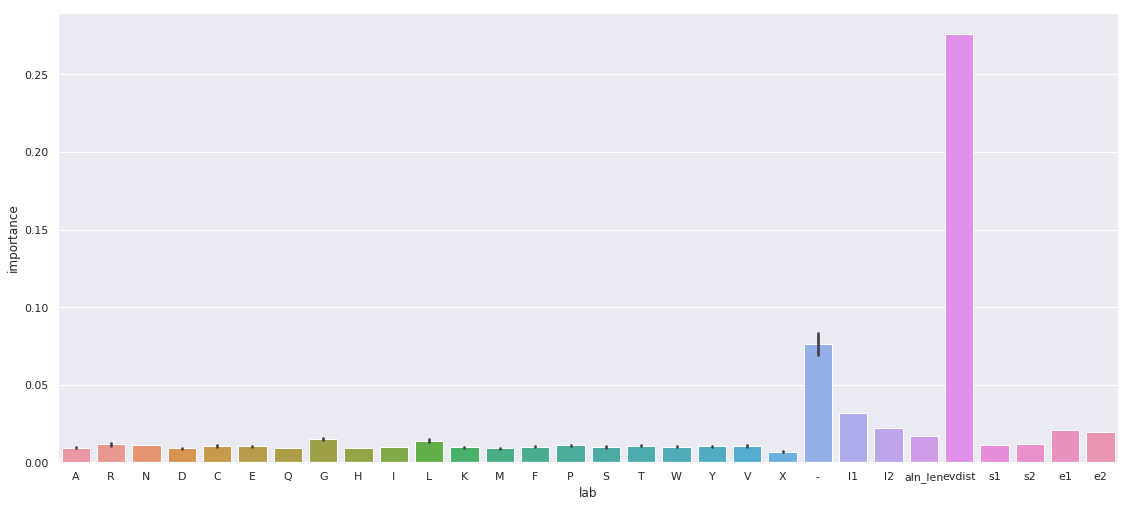

In [90]:
labels = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X', '-', 'A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X', '-', 'l1', 'l2', 'aln_len', 'evdist','s1', 's2', 'e1', 'e2']
imp_df = pd.DataFrame({'lab':labels, 'importance':importances})
sns.barplot(x='lab', y='importance', data = imp_df)
sns.set(rc={'figure.figsize':(19,8.27)})
plt.show()

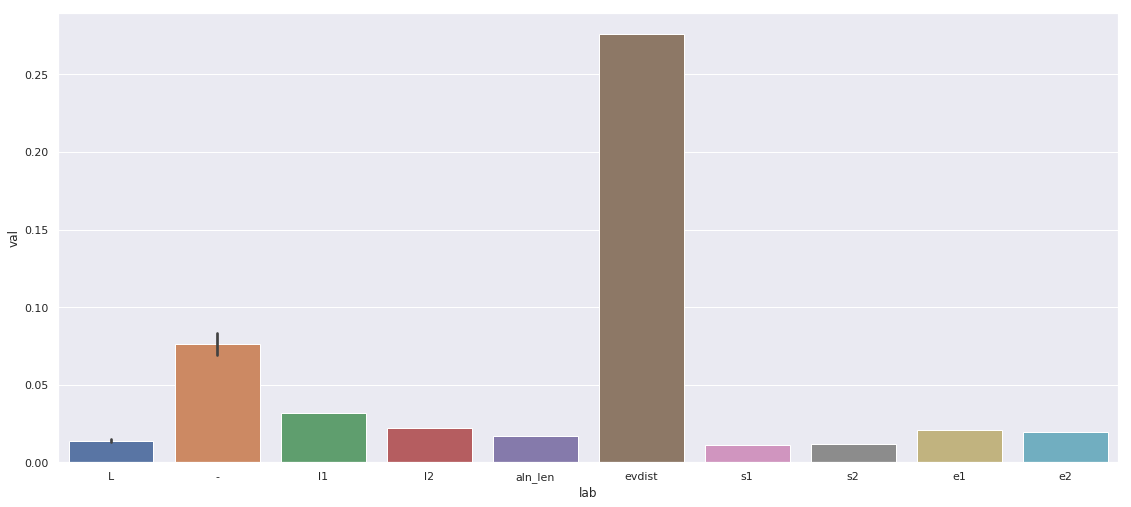

In [91]:
#It looks like Leucine, gaps, lengths of sequences and alignment as well as the evdist are the important features
importances_s = [importances[10],importances[21],importances[32],importances[43],importances[44],importances[45],importances[46],importances[47],importances[48],importances[49],importances[50],importances[51]]
labels = ['L', '-', 'L', '-', 'l1', 'l2', 'aln_len', 'evdist','s1', 's2', 'e1', 'e2']
imp_df = pd.DataFrame({'lab':labels, 'val':importances_s})
sns.barplot(x='lab', y='val', data = imp_df)
sns.set(rc={'figure.figsize':(19,8.27)})
plt.show()

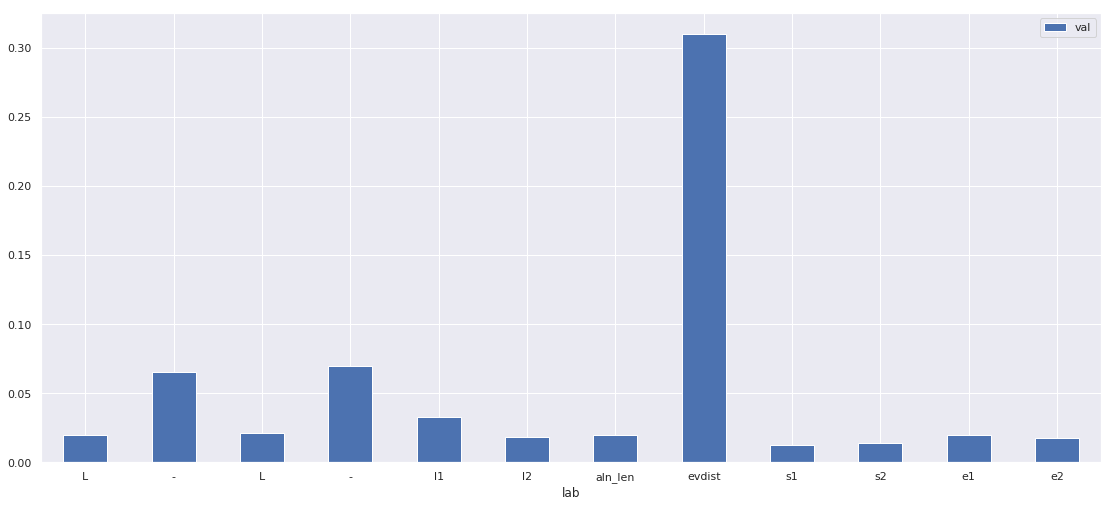

In [48]:
imp_df.plot.bar(x='lab', y='val',rot=0)

In [49]:
#Adaboost
clf = AdaBoostRegressor(random_state=0, n_estimators=7) #int asssignment of random state ensures same random intitator each run
# Fit on training data
clf.fit(X_train, y_train)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid))
print(average_error)

#Binned fitting
# Fit on training data
clf.fit(X_train, y_train_binned)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid_binned))
print(average_error*0.1)


0.2967062716497958
0.2943713238756529


In [3]:
#Using PROFILE representations of alignments
#Read df
complete_with_hmm_df = pd.read_csv('/home/pbryant/results/CATH/20190606/complete_with_hmm_df.csv')

In [72]:
def save_nparray(H_group_data, group, column):
    index = H_group_data.index
    for i in range(index[0], index[-1]+1):
        uid1 = H_group_data['uid1'][i]
        uid2 = H_group_data['uid2'][i]
        name = '/home/pbryant/results/CATH/20190606/'+group+'/'+uid1+'_'+uid2+'.'+column+'.txt'
        t1 = hmm_to_array(H_group_data[column][i])
        np.savetxt(name, t1, fmt='%d')


def hmm_to_array(tx):
    '''Convert hmm to array, replace * with 0
    '''
    tx = literal_eval(tx)
    for i in range(0,len(tx)):
        for j in range(0, len(tx[i])):
            if tx[i][j] == '*':
                tx[i][j] = 0
            else:
                tx[i][j] = int(tx[i][j])
            np.asarray(tx[i])
    return(np.asarray(tx))


In [48]:
groups = Counter(complete_with_hmm_df['H_group_x'])
groups = [*groups.keys()]
for group in groups:
    os.mkdir('/home/pbryant/results/CATH/20190606/'+group)
    H_group_data =  complete_with_hmm_df[complete_with_hmm_df['H_group_x']==group]
    save_nparray(H_group_data, group)

In [51]:
#hmm2
for group in groups:
    H_group_data =  complete_with_hmm_df[complete_with_hmm_df['H_group_x']==group]
    save_nparray(H_group_data, group, 'hmm_list2')

In [73]:
#Transition frequencies and local divergences
columns = ['transition_freq1', 'transition_freq2', 'local_div1', 'local_div2']
for column in columns:
    for group in groups:
        H_group_data =  complete_with_hmm_df[complete_with_hmm_df['H_group_x']==group]
        save_nparray(H_group_data, group, column)

In [62]:
#LOAD
hmm1 = {}
base = '/home/pbryant/results/CATH/20190606/'
for group in groups:
    H_group_data = complete_with_hmm_df[complete_with_hmm_df['H_group_x']==group]
    uid1 = [*H_group_data['uid1']]
    uid2 = [*H_group_data['uid2']]
    for i in range(0,len(uid1)):
        name = uid1[i]+'_'+uid2[i]
        c = np.loadtxt(base+group+'/'+name+'.hmm1.txt', dtype=int)
        hmm1[name] = c



In [158]:
hmm2 = {}
transition_freq1= {}
transition_freq2= {}
local_div1= {}
local_div2= {}

columns = ['hmm2','transition_freq1', 'transition_freq2', 'local_div1', 'local_div2']
base = '/home/pbryant/results/CATH/20190606/'
for group in groups:
    H_group_data = complete_with_hmm_df[complete_with_hmm_df['H_group_x']==group]
    uid1 = [*H_group_data['uid1']]
    uid2 = [*H_group_data['uid2']]
    for i in range(0,len(uid1)):
        name = uid1[i]+'_'+uid2[i]
        a = np.loadtxt(base+group+'/'+name+'.hmm2.txt', dtype=int)
        b = np.loadtxt(base+group+'/'+name+'.transition_freq1.txt', dtype=int)
        c = np.loadtxt(base+group+'/'+name+'.transition_freq2.txt', dtype=int)
        d = np.loadtxt(base+group+'/'+name+'.local_div1.txt', dtype=int)
        e = np.loadtxt(base+group+'/'+name+'.local_div2.txt', dtype=int)
        hmm2[name] = a
        transition_freq1[name] =b
        transition_freq2[name] =c
        local_div1[name] =d
        local_div2[name] =e



In [71]:
#Convert * to 0 and rest to ints
for i in range(0, len(hmm_list1)):
    item = hmm_list1[i]
    for j in range(0, len(item)):
        for k in range(0, len(item[j])):
            if item[j][k] == '*':
                item[j][k] = 0
            else:
                item[j][k] = int(item[j][k])
           
    hmm_list1[i] = np.asarray(item)
hmm_list1 = np.asarray(hmm_list1)

In [160]:
h5.close()
h5 = tables.open_file('/home/pbryant/results/CATH/20190606/data.h5', 'w', filters=tables.Filters(9, 'blosc:snappy'))


# Create a group (~folder) and put stuff inside
for hgroup in groups:
    hgroup_s = hgroup.split('.')
    group = h5.create_group(h5.root,'h_'+hgroup_s[0]+'_'+hgroup_s[1]+'_'+hgroup_s[2]+'_'+hgroup_s[3])
    group_data = complete_with_hmm_df[complete_with_hmm_df['H_group_x']==hgroup]
    uid1 = [*group_data['uid1']]
    uid2 = [*group_data['uid2']]
    for i in range(0, len(uid1)):
        h5.create_carray(group, 'hmm1_'+uid1[i]+'_'+uid2[i], obj=hmm1[uid1[i]+'_'+uid2[i]])
        h5.create_carray(group, 'hmm2_'+uid1[i]+'_'+uid2[i], obj=hmm2[uid1[i]+'_'+uid2[i]])
        h5.create_carray(group, 'tf1_'+uid1[i]+'_'+uid2[i], obj=transition_freq1[uid1[i]+'_'+uid2[i]])
        h5.create_carray(group, 'tf2_'+uid1[i]+'_'+uid2[i], obj=transition_freq2[uid1[i]+'_'+uid2[i]])
        h5.create_carray(group, 'ld1_'+uid1[i]+'_'+uid2[i], obj=local_div1[uid1[i]+'_'+uid2[i]])
        h5.create_carray(group, 'ld2_'+uid1[i]+'_'+uid2[i], obj=local_div2[uid1[i]+'_'+uid2[i]])
h5.close()

In [ ]:
def create_features(df):
    '''Get features
    '''
    #Open h5
    h5 = tables.open_file('/home/pbryant/results/CATH/20190606/data.h5')
    #Get H_groups
    groups = [*df['H_group_x']]
    
    #Get MLAAdist
    evdist = np.asarray(df['MLAAdist_x'])
    
            
    #Save features
    enc_feature = []
    
    #Get hmms
    for hgroup in groups:
        group_data = df[df['H_group_x']==hgroup]
        uid1 = [*group_data['uid1']]
        uid2 = [*group_data['uid2']]
        
        #Get lengths
        l1 = np.asarray(group_data['l1'])
        l2 = np.asarray(group_data['l2'])
        aln_len = np.asarray(group_data['aln_len'])
        #Get starts and ends
        s1 = np.asarray(group_data['s1'])
        s2 = np.asarray(group_data['s2'])
        e1 = np.asarray(group_data['e1'])
        e2 = np.asarray(group_data['e2'])
    
        hgroup_s = hgroup.split('.')
        group_name = 'h_'+hgroup_s[0]+'_'+hgroup_s[1]+'_'+hgroup_s[2]+'_'+hgroup_s[3]
        for i in range(0,len(uid1)):
            uids = uid1[i]+'_'+uid2[i]
            hmm1 = np.concatenate(h5.root[group_name]['hmm1_'+uids][:])
            hmm2 = np.concatenate(h5.root[group_name]['hmm2_'+uids][:])
            tf1 = np.concatenate(h5.root[group_name]['tf1_'+uids][:])
            tf2 = np.concatenate(h5.root[group_name]['tf2_'+uids][:])
            ld1 = np.concatenate(h5.root[group_name]['ld1_'+uids][:])
            ld2 = np.concatenate(h5.root[group_name]['ld2_'+uids][:])
            
            #Pad
            hmm1 = np.pad(hmm1, (0,758*20-len(hmm1)), 'constant')
            hmm2 = np.pad(hmm2, (0,758*20-len(hmm2)), 'constant')
            tf1 = np.pad(tf1, (0,758*7-len(tf1)), 'constant')
            tf2 = np.pad(tf2, (0,758*7-len(tf2)), 'constant')
            ld1 = np.pad(ld1, (0,758*3-len(ld1)), 'constant')
            ld2 = np.pad(ld2, (0,758*3-len(ld2)), 'constant')
            
            cat = np.concatenate((hmm1, hmm2, tf1, tf2, ld1, ld2), axis = 0)
            
            np.append(cat, l1[i])
            np.append(cat, l2[i])        
            np.append(cat, aln_len[i])
            np.append(cat, evdist[i])
            np.append(cat, s1[i])
            np.append(cat, s2[i])
            np.append(cat, e1[i])
            np.append(cat, e2[i])
            
            enc_feature.append(cat) #Append to list

    #Get RMSDs - should probably normalize with value 4,5 ?
    rmsds = df['RMSD_x']
    bins = np.arange(0,4.5,0.1)
    #bins = np.arange(0.5,2.5,0.05)
    #bins = np.insert(bins,0, 0)
    #bins = np.append(bins, 4.5)
    #Bin the TMscore RMSDs
    binned_rmsds = np.digitize(rmsds, bins)

    #Data
    X = np.asarray(enc_feature)
    y = np.asarray(rmsds)
    y_binned = np.asarray(binned_rmsds) 
    
    #Close h5 file
    h5.close()
    return(X, y, y_binned)

#Get array
h5 = tables.open_file('/home/pbryant/results/CATH/20190606/data.h5')
#h5.root.h_1_10_1000_11.hmm1_1ku1A02_1re0B02[:]
#Run Split above first
#Padding
maxlen=758
#Time process
start_time = time.time()
X_train,y_train, y_train_binned = create_features(train_df)
print("--- %s seconds ---" % (time.time() - start_time))
pdb.set_trace()
X_valid,y_valid, y_valid_binned = create_features(valid_df)